<a href="https://colab.research.google.com/github/ryota-katsube/quantum_exercise/blob/master/%E9%87%8F%E5%AD%90%E5%9B%9E%E8%B7%AF%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#qiskitのインストール
!pip install qiskit

In [ ]:
#ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

# 量子回路学習

・原論文
Kosuke Mitarai, Makoto Negoro, Masahiro Kitagawa, Keisuke Fujii Phys. Rev. A 98, 032309 (2018)
https://arxiv.org/abs/1803.00745v3
・御手洗さんと藤井さんによる日本語の解説記事
https://www.jps.or.jp/books/gakkaishi/2019/09/74-09seriesAIphys1.pdf

 ・5ビットの量子コンピュータで実証実験した論文
 V. Havlicek et al. , “Supervised learning with quantum-enhanced feature spaces”, Nature 567, 209–212 (2019), arXiv版：https://arxiv.org/abs/1804.11326

Qulacsを用いたプログラム実装の例がhttps://dojo.qulacs.org/ja/latest/notebooks/5.2_Quantum_Circuit_Learning.html に載っている

## Qiskitを用いた実装

In [ ]:
#学習データの作成

# [x_min, x_max]から, ランダムにnum_x_train個の点をとって教師データにする
x_min = - 1.; x_max = 1.;
num_x_train = 50

# 学習したい関数
func_to_learn = lambda x: x**2 + np.sin(x*np.pi)

# 乱数のシード
random_seed = 0
# 乱数発生器の初期化
np.random.seed(random_seed)

In [ ]:
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

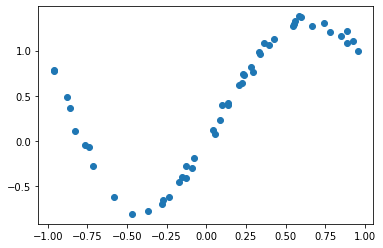

In [ ]:
#データにノイズ
mag_noise = 0.05

# 乱数のシード
random_seed = 1
# 乱数発生器の初期化
np.random.seed(random_seed)

y_train = y_train + mag_noise * np.random.randn(num_x_train)

#データをプロット
plt.plot(x_train, y_train, "o"); plt.show()

In [ ]:
#データを量子状態にエンコーディングする回路
def encoding_circ(x,nqubits):

  qc = QuantumCircuit(nqubits,nqubits)

  angle_y = np.arcsin(x)
  angle_z = np.arccos(x**2)

  for i in range(nqubits):
      qc.ry(angle_y, i)
      qc.rz(angle_z, i)
       
  return qc

In [ ]:
#encodingの回路の図示
#使う量子ビット数
nqubits = 3
qc = encoding_circ(0.1,nqubits)
qc.draw()

┌─────────────┐┌────────────┐
q_0: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├
     ├─────────────┤├────────────┤
q_1: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├
     ├─────────────┤├────────────┤
q_2: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├
     └─────────────┘└────────────┘
c: 3/═════════════════════════════

In [ ]:
#イジング相互作用のゲートを作用させる。
def ising_circ(qc,nqubits):
  for i in range(nqubits):
    seed =  i + 6
    np.random.seed(seed)
    qc.rx(2 * np.random.rand()*2*np.pi, i) 
    
  for i in range(nqubits):
    for j in range(i):
      seed = i+j
      np.random.seed(seed) #乱数をi+jに固定
      qc.rzz(2 * np.random.rand()*2*np.pi, i,j) 
       
  return qc

In [ ]:
#イジング相互作用をかけたところまでの回路図
qc = ising_circ(qc,nqubits)
qc.draw()

┌─────────────┐┌────────────┐ ┌───────────┐                           »
q_0: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(11.22) ├──■────────────■───────────»
     ├─────────────┤├────────────┤┌┴───────────┴┐ │ZZ(5.2405)  │           »
q_1: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├┤ Rx(0.95892) ├─■────────────┼───────────»
     ├─────────────┤├────────────┤└┬────────────┤              │ZZ(5.4789) »
q_2: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(10.976) ├──────────────■───────────»
     └─────────────┘└────────────┘ └────────────┘                          »
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«                  
«q_0: ─────────────
«                  
«q_1: ─■───────────
«      │ZZ(6.9215) 
«q_2: ─■───────────
«                  
«c: 3/═════════════
«

In [ ]:
#パラメータつきの回転ゲートを作用させる
def rotation_circ(qc,theta,nqubits):
  
  #thetaはnquits*3個の成分をもつ1次元配列

  for i in range(nqubits):
    qc.rx(2 * theta[0+i*3]*2*np.pi, i)
    qc.rz(2 * theta[1+ i * 3]*2*np.pi, i)
    qc.rx(2 * theta[2 + i*3]*2*np.pi,i)
     
  return qc

In [ ]:
#パラメータつきの回転ゲートをかけたところまでの回路図
theta = np.ones(3*nqubits)
qc = rotation_circ(qc,theta,nqubits)
qc.draw()

┌─────────────┐┌────────────┐ ┌───────────┐                           »
q_0: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(11.22) ├──■────────────■───────────»
     ├─────────────┤├────────────┤┌┴───────────┴┐ │ZZ(5.2405)  │           »
q_1: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├┤ Rx(0.95892) ├─■────────────┼───────────»
     ├─────────────┤├────────────┤└┬────────────┤              │ZZ(5.4789) »
q_2: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(10.976) ├──────────────■───────────»
     └─────────────┘└────────────┘ └────────────┘                          »
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«       ┌────────┐ ┌────────┐┌────────┐          
«q_0: ──┤ Rx(4π) ├─┤ Rz(4π) ├┤ Rx(4π) ├──────────
«       └────────┘ ├────────┤├────────┤┌────────┐
«q_1: ─■───────────┤ Rx(4π) ├┤ Rz(4π) ├┤ Rx(4π) ├
«      │ZZ(6.9215) ├────────┤├────────┤├────────┤
«q_2: ─■───────────┤ Rx(4π) ├┤ Rz(4π) ├┤ Rx(4π) ├
«                  └────────┘└────────┘└────────┘
«c: 3/═══════════════════════════════════════════
«

In [ ]:
#測定の回路。
def measure(qc):
  qc.measure(np.arange(nqubits),np.arange(nqubits))
  return qc

In [ ]:
#測定までの回路図
measure(qc)
qc.draw()

┌─────────────┐┌────────────┐ ┌───────────┐                           »
q_0: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(11.22) ├──■────────────■───────────»
     ├─────────────┤├────────────┤┌┴───────────┴┐ │ZZ(5.2405)  │           »
q_1: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├┤ Rx(0.95892) ├─■────────────┼───────────»
     ├─────────────┤├────────────┤└┬────────────┤              │ZZ(5.4789) »
q_2: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(10.976) ├──────────────■───────────»
     └─────────────┘└────────────┘ └────────────┘                          »
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«       ┌────────┐ ┌────────┐┌────────┐          ┌─┐      
«q_0: ──┤ Rx(4π) ├─┤ Rz(4π) ├┤ Rx(4π) ├──────────┤M├──────
«       └────────┘ ├────────┤├────────┤┌────────┐└╥┘┌─┐   
«q_1: ─■───────────┤ Rx(4π) ├┤ Rz(4π) ├┤ Rx(4π) ├─╫─┤M├───
«      │ZZ(6.9215) ├────────┤├────────┤├────────┤ ║ └╥┘┌─┐
«q_2: ─■───────────┤ Rx(4π) ├┤ Rz(4π) ├┤ Rx(4π) ├─╫──╫─┤M├
«                  └────────┘└────────┘└────────┘ ║  ║ └╥┘
«c: 3/════════════════════════════════════════════╩══╩══╩═
«                                                 0  1  2

In [ ]:
#全体の回路
def qcl_circ(x,theta,nqubits):
  #thetaは回路の深さ*3*nqubitsの成分をもつ1次元配列

  qc = encoding_circ(x,nqubits)

  p = len(theta)// (3 * nqubits) 
  for iter in range(p):
    qc = ising_circ(qc,nqubits)
    para = theta[iter*3*nqubits:(iter+1)*3*nqubits]
    qc = rotation_circ(qc,para,nqubits)

  qc = measure(qc)

  return qc  


In [ ]:
#深さpの全体の回路の図示
p = 2
nqubits = 3
x=0.1
theta = np.ones(3*p*nqubits)
np.random.seed(10)
theta = 2*np.pi*np.random.rand(3*p*nqubits)
qc = qcl_circ(x,theta,nqubits)
qc.draw()


┌─────────────┐┌────────────┐ ┌───────────┐                           »
q_0: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(11.22) ├──■────────────■───────────»
     ├─────────────┤├────────────┤┌┴───────────┴┐ │ZZ(5.2405)  │           »
q_1: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├┤ Rx(0.95892) ├─■────────────┼───────────»
     ├─────────────┤├────────────┤└┬────────────┤              │ZZ(5.4789) »
q_2: ┤ Ry(0.10017) ├┤ Rz(1.5608) ├─┤ Rx(10.976) ├──────────────■───────────»
     └─────────────┘└────────────┘ └────────────┘                          »
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌────────────┐┌────────────┐┌────────────┐┌───────────┐                »
«q_0: ┤ Rx(60.901) ├┤ Rz(1.6385) ├┤ Rx(50.031) ├┤ Rx(11.22) ├────────────────»
«     └────────────┘├────────────┤├────────────┤├───────────┴┐┌─────────────┐»
«q_1: ─■────────────┤ Rx(59.123) ├┤ Rz(39.361) ├┤ Rx(17.749) ├┤ Rx(0.95892) ├»
«      │ZZ(6.9215)  ├────────────┤├────────────┤├────────────┤└┬────────────┤»
«q_2: ─■────────────┤ Rx(15.638) ├┤ Rz(60.049) ├┤ Rx(13.352) ├─┤ Rx(10.976) ├»
«                   └────────────┘└────────────┘└────────────┘ └────────────┘»
«c: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                               ┌───────────┐ ┌────────────┐┌────────────┐»
«q_0: ─■────────────■───────────┤ Rx(6.975) ├─┤ Rz(54.114) ├┤ Rx(75.277) ├»
«      │ZZ(5.2405)  │           └───────────┘┌┴────────────┤├────────────┤»
«q_1: ─■────────────┼────────────■───────────┤ Rx(0.31174) ├┤ Rz(40.441) ├»
«                   │ZZ(5.4789)  │ZZ(6.9215) └┬────────────┤├────────────┤»
«q_2: ──────────────■────────────■────────────┤ Rx(48.363) ├┤ Rz(56.988) ├»
«                                             └────────────┘└────────────┘»
«c: 3/════════════════════════════════════════════════════════════════════»
«                                                                         »
«                   ┌─┐      
«q_0: ──────────────┤M├──────
«     ┌────────────┐└╥┘┌─┐   
«q_1: ┤ Rx(64.162) ├─╫─┤M├───
«     ├────────────┤ ║ └╥┘┌─┐
«q_2: ┤ Rx(23.046) ├─╫──╫─┤M├
«     └────────────┘ ║  ║ └╥┘
«c: 3/═══════════════╩══╩══╩═
«                    0  1  2

In [ ]:
#一つの測定結果が与えられたときの期待値を計算
def weight(x,para,nqubits):
  y = list(x)
  y = np.array(y)
  #qiskitのビット列の表示は逆順なので順番を直す
  z = np.zeros(nqubits)
  for i in range(nqubits):
    z[nqubits-1 -i] = y[i]    

  weight = 0 
  for i in range(nqubits): 
    if z[i] == 0:
       weight = weight + 1*para[i]
    else:
       weight = weight + (-1)*para[i]

  return weight

def compute_expectation(counts,para,nqubits):
  sum = 0
  sum_count = 0
  for bitstring, count in counts.items():
      w = weight(bitstring,para,nqubits)
      sum += w * count
      sum_count += count
      
  return sum/sum_count



In [ ]:
#ある一つのデータに対してコスト関数を出す
def cost_function(x_list,y_list,nqubits,p):

  backend = Aer.get_backend('qasm_simulator')
  backend.shots = 1000
  
  def execute_circ(opti_para):
      theta = opti_para[0:3*p*nqubits]
      para = opti_para[3*p*nqubits:]
      cost = 0
      for i in range(len(x_list)):
        qc = qcl_circ(x_list[i],theta,nqubits)
        counts = backend.run(qc, seed_simulator=10, 
                            shots=1000).result().get_counts()

        y_pred = compute_expectation(counts,para,nqubits)

        cost += (y_pred - y_list[i])**2
      
      return cost

  
  return execute_circ

In [ ]:
#勾配法を使わないで最適化した場合
nqubits = 3
p = 4
theta = np.ones(3*p*nqubits+nqubits)
np.random.seed(10)
theta = np.random.rand(3*p*nqubits+nqubits)

expectation = cost_function(x_train,y_train,nqubits,p)

res = minimize(expectation, 
                      theta, 
                      method='COBYLA')

#最適なパラメータをresに記憶
res


     fun: 0.43481191180142553
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 515
  status: 1
 success: True
       x: array([ 7.74878314e-01,  1.97140890e-02,  6.30311834e-01,  7.55401924e-01,
        5.08682088e-01,  2.26826193e-01,  1.93617165e-01,  7.57515599e-01,
        1.74732017e-01,  7.82280299e-02,  6.90014660e-01,  9.47408636e-01,
        6.82416459e-03,  5.18444137e-01,  8.23465262e-01,  6.12934048e-01,
        7.20147374e-01,  3.04368532e-01,  8.88660044e-01,  7.22913631e-01,
        5.35971522e-01,  1.42638771e-01,  3.89110259e-01,  6.72768604e-01,
        4.41520540e-01,  4.20872907e-01,  6.22362774e-01,  5.12886939e-01,
        6.52577716e-01,  6.07296636e-01,  8.22164480e-01,  5.16394941e-01,
        9.06072980e-01,  3.10349693e-01,  9.60248736e-02,  2.99673412e-01,
       -2.63698571e-04,  3.20854472e+00,  2.30038481e+00])

In [ ]:
#予測結果を計算
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1000
x_list = np.arange(x_min, x_max, 0.02)
y_list = np.zeros(len(x_list))
theta = res.x[0:3*p*nqubits]
for i in range(len(x_list)):
  qc = qcl_circ(x_list[i],theta,nqubits)
  counts = backend.run(qc, seed_simulator=10, 
                            shots=1000).result().get_counts()
                         
  para = res.x[3*p*nqubits:]
  y_list[i] = compute_expectation(counts,para,nqubits)

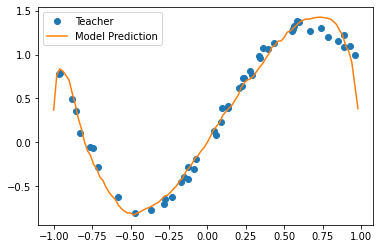

In [ ]:
#結果の図示
# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# モデルの予測値
plt.plot(x_list, y_list, label='Model Prediction')

plt.legend()
plt.show()

実行結果(p=4,n=3)
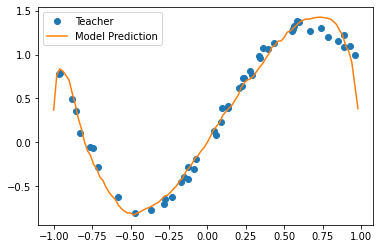

##勾配法 
測定物理量$H$は今の場合、$$ H = \sum_i^{n} a_i Z_i $$
である。予測値 $y_{pred}$ は
$$ y_{pred} = <H(\theta)>$$である。
コスト関数は
$$L = (<H(\theta)>-y_{pred})^2 $$で定義される。
パラメータの微分は
$$ \frac{\partial L}{\partial \theta}= (<H(\theta)>-y_{pred})\left[\left<H\left(\theta+\frac{\pi}{2}\right)\right>-\left<H\left(\theta - \frac{\pi}{2}\right)\right>\right] $$
$$ \frac{\partial L}{\partial a_i} = 2 (<H(\theta)>-y_{pred}) <Z_j(\theta)> $$
で求めることができる。1つ目の勾配公式はパラメータシフトルールと言われている。
勾配が分かれば勾配降下法を使ってパラメータ更新ができる。ただし、勾配法を使う場合1回の更新で2回パラメータシフトさせて量子回路を動かす必要がある。



In [ ]:
#勾配法をつかったパラメータ更新で学習する場合
nqubits = 3
p = 4

opti_para = np.ones(3*p*nqubits+nqubits)
np.random.seed(10)
opti_para = np.random.rand(3*p*nqubits+nqubits)

backend = Aer.get_backend('qasm_simulator')
backend.shots = 250

num_iter = 40
eta = 0.01

theta = opti_para[0:3*p*nqubits]
para = opti_para[3*p*nqubits:]
cost_hist = []
for i in range(num_iter):
    cost = 0
    for j in range(len(x_train)):
        qc = qcl_circ(x_train[j],theta,nqubits)
        counts = backend.run(qc, seed_simulator=10, 
                            shots=250).result().get_counts()

        y_pred = compute_expectation(counts,para,nqubits)

        diff = y_pred - y_train[j]

        cost += diff **2

        new_theta = np.zeros(3*p*nqubits)

        for k in range(3*p*nqubits):

          temp = np.zeros(3*p*nqubits)
          temp[k] = np.pi / 2

          qc_temp = qcl_circ(x_train[j],theta+temp,nqubits)
          counts = backend.run(qc_temp, seed_simulator=10, 
                            shots=250).result().get_counts()

          y_temp1 = compute_expectation(counts,para,nqubits)

          qc_temp = qcl_circ(x_train[j],theta-temp,nqubits)
          counts = backend.run(qc_temp, seed_simulator=10, 
                            shots=250).result().get_counts()
          y_temp2 = compute_expectation(counts,para,nqubits)                    

          gradient = diff * (y_temp1 - y_temp2)

          new_theta[k] = theta[k] - eta * gradient
        
        new_para = np.zeros(nqubits)
        for k in range(nqubits):
          temp = np.zeros(nqubits)
          temp[k] = 1
          counts = backend.run(qc, seed_simulator=10, 
                            shots=250).result().get_counts()

          y_temp3 = compute_expectation(counts,temp,nqubits)
          gradient = 2 * diff *y_temp3
          new_para[k] = para[k] - eta * gradient

        theta = new_theta
        para = new_para
    cost_hist.append(cost)

final_theta = theta
final_para = para

print(cost)

0.6022872119457794


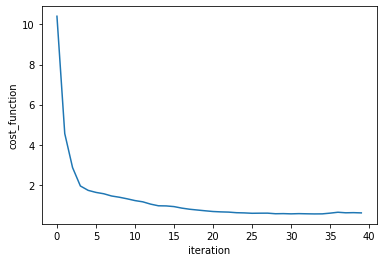

In [ ]:
plt.plot(cost_hist)
plt.xlabel("iteration")
plt.ylabel("cost_function")
plt.show()

In [ ]:
#予測結果を計算
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1000
x_list = np.arange(x_min, x_max, 0.02)
y_list2 = np.zeros(len(x_list))

for i in range(len(x_list)):
  qc = qcl_circ(x_list[i],final_theta,nqubits)
  counts = backend.run(qc, seed_simulator=10, 
                            shots=1000).result().get_counts()
                         
  y_list2[i] = compute_expectation(counts,final_para,nqubits)

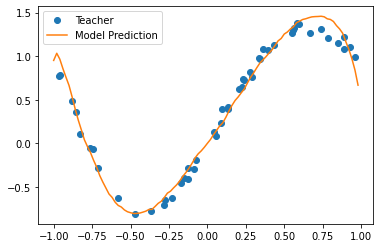

In [ ]:
#結果の図示
# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# モデルの予測値
plt.plot(x_list, y_list2, label='Model Prediction')

plt.legend()
plt.show()

nqubits= 3,p=4,num_iter=30のとき
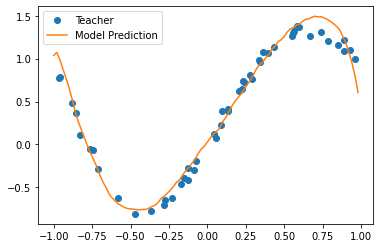